## Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


__


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time

C:\Users\erol.erdogan\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
data_train = pd.read_csv("train.csv", encoding="latin-1", low_memory=False)
data_test = pd.read_csv("test.csv", encoding='latin-1')
address_data = pd.read_csv("addresses.csv", encoding="latin-1")
latlons_data = pd.read_csv("latlons.csv")

#Merging address and Iat-Ion datas into main data
data_train = data_train.merge(address_data, on="ticket_id")
data_train = data_train.merge(latlons_data, on="address")

# Data Cleaning / Manipulation

In [3]:
# Dropping NaN data on Compliance to not affect training
data_train.dropna(subset=["compliance"], how="any", inplace=True)

# Dropping unnecessary / useless / 0 values from training and test datasets
data_train.drop(["violation_zip_code", "violation_street_number","violation_street_name","clean_up_cost", "non_us_str_code", 
                "grafitti_status", "violator_name", "mailing_address_str_number", 
                 "mailing_address_str_name", 'city', 'zip_code', 'ticket_issued_date', 'hearing_date',
                 'admin_fee', 'state_fee', 'address', 'lat', 'lon', "payment_date"],
                axis=1, inplace=True)
data_test.drop(["violation_zip_code", "violation_street_number","violation_street_name","clean_up_cost", "non_us_str_code", 
                "grafitti_status", "violator_name", "mailing_address_str_number", 
                 "mailing_address_str_name", 'city', 'zip_code', 'ticket_issued_date', 'hearing_date',
                 'admin_fee', 'state_fee'],
                axis=1, inplace=True)

In [4]:
# Converting categorical columns to 0 or 1 
data_train_converted = pd.get_dummies(data_train[["agency_name", "country", "disposition", "violation_description",
                                                  "inspector_name", "state" 
                              ]], prefix_sep="_").join(data_train[["ticket_id", 
                                                                   "fine_amount", "late_fee", "judgment_amount", 
                                                                   "compliance"]]).set_index("ticket_id")

data_test_converted = pd.get_dummies(data_test[["agency_name", "country", "disposition", "violation_description",
                                                  "inspector_name", "state" 
                              ]], prefix_sep="_").join(data_test[["ticket_id", 
                                                                   "fine_amount", "late_fee", "judgment_amount", 
                                                                   ]]).set_index("ticket_id")

# Feature Selection

## Before Feature Selection methods have been applied

In [39]:
X = data_train_converted.drop(["compliance"], axis=1)
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

start = time.process_time()
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=101).fit(X_train, y_train)
print("Once the feature selection haven't been applied to the dataset;\n""Time: ", time.process_time() - start)

predictions = random_forest_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
print("AUC score: ", auc(fpr, tpr))

Once the feature selection haven't been applied to the dataset;
Time:  10.375
AUC score:  0.507907133243607


## Univariate Feature Selection

In [42]:
from sklearn.feature_selection import SelectKBest, chi2

X = data_train_converted.iloc[:,:-1]
y = data_train_converted["compliance"]

univariate_selection = SelectKBest(score_func=chi2, k=20).fit(X, y)
univariate_best_features = pd.DataFrame(univariate_selection.scores_, index=X.columns, columns=["Scores"])
univariate_best_features.nlargest(10, columns="Scores")

#Choosing 5 of them. Because there is a breaking point
train_highest_univariate = univariate_best_features.nlargest(10, columns="Scores").index

X = data_train_converted[train_highest_univariate]
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

start = time.process_time()
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=101).fit(X_train, y_train)
print("Once the Univariate Selection approach has been applied to the dataset;\n""Time:", time.process_time() - start)

predictions = random_forest_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
print("AUC score: ", auc(fpr, tpr))

Once the Univariate Selection approach has been applied to the dataset;
Time: 4.140625
AUC score:  0.5798286666690434


##                              Feature Selection w/ Correlation Matrix

<IPython.core.display.Javascript object>


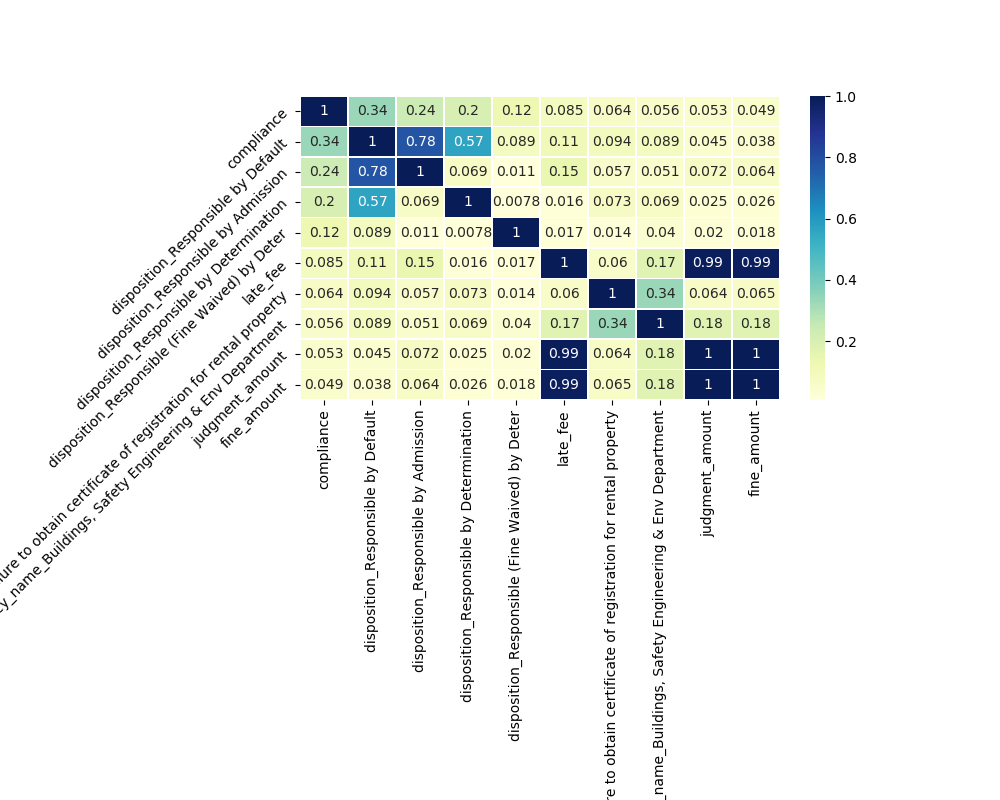

disposition_Responsible by Default                                                         0.335455
disposition_Responsible by Admission                                                       0.238997
disposition_Responsible by Determination                                                   0.202819
disposition_Responsible (Fine Waived) by Deter                                             0.124956
late_fee                                                                                   0.085055
violation_description_Failure to obtain certificate of registration for rental property    0.064205
agency_name_Buildings, Safety Engineering & Env Department                                 0.055637
judgment_amount                                                                            0.052637
fine_amount                                                                                0.049134
Name: compliance, dtype: float64


In [34]:
#Feature selection. Selecting corr < 0.1  highest feature correlation based on correlation matrix
train_highest_corr = data_train_converted.corr().abs()["compliance"].nlargest(10).index

df_corr_matrix = data_train_converted[train_highest_corr]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_corr_matrix.corr().abs(), annot=True, lw=.5, cmap="YlGnBu" )
plt.subplots_adjust(left=.3, bottom=.5)
plt.yticks(rotation=45);
print(data_train_converted.corr().abs()["compliance"].nlargest(10).drop(["compliance"]))

In [35]:
X = data_train_converted[train_highest_corr].drop(["compliance"], axis=1)
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

start = time.process_time()
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=101).fit(X_train, y_train)
print("Once the 'Correlation Matrix' approach has been applied to the dataset;\n""Time: ", time.process_time() - start)

predictions = random_forest_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
print("AUC score: ", auc(fpr, tpr))

Once the 'Correlation Matrix' approach has been applied to the dataset;
Time:  4.015625
AUC score:  0.5790009965254387


## Feature Selection w/ Feature Importances of RandomForestClassifier

<IPython.core.display.Javascript object>


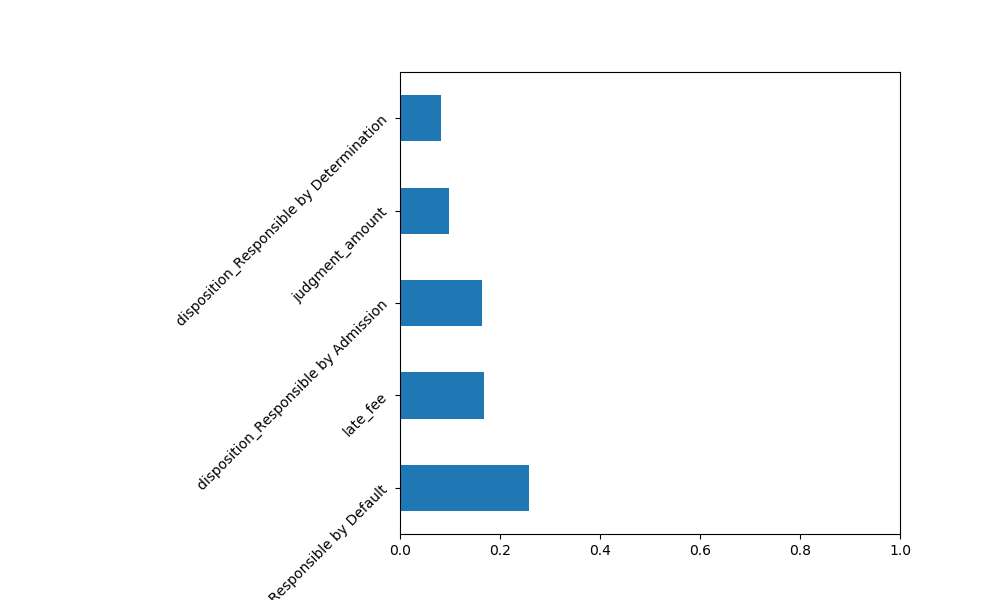

disposition_Responsible by Default                                                                        0.258411
late_fee                                                                                                  0.167959
disposition_Responsible by Admission                                                                      0.163269
judgment_amount                                                                                           0.098851
disposition_Responsible by Determination                                                                  0.081978
fine_amount                                                                                               0.060589
disposition_Responsible (Fine Waived) by Deter                                                            0.060219
violation_description_Failure to obtain certificate of registration for rental property                   0.012654
agency_name_Detroit Police Department                                           

In [40]:
feature_importances = pd.Series(random_forest_model.feature_importances_,
                                index=X.columns)

fig, ax = plt.subplots(figsize=(10,6))
feature_importances.nlargest(5).plot(kind="barh")
plt.subplots_adjust(left=.4)
plt.yticks(rotation=45)
plt.xlim(0,1)
print(feature_importances.nlargest(10))

#Feature selection. Selecting corr < 0.1  highest feature correlation based on correlation matrix
train_highest_importance = feature_importances.nlargest(5).index

In [41]:
X = data_train_converted[train_highest_importance]
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

start = time.process_time()
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=101).fit(X_train, y_train)
print("Once the 'Feature Importance' approach has been applied to the dataset;\n""Time:", time.process_time() - start)

predictions = random_forest_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)
print("AUC score: ", auc(fpr, tpr))

Once the 'Feature Importance' approach has been applied to the dataset;
Time: 3.15625
AUC score:  0.5786645227703916


## Decision of which Feature Selection Approach gives best score on AUC

**-----------------------------------------------------------------------------------------------------------------------------------------------------**

**Once the Feature selection methods haven't been applied to the dataset;**

Time:  10.375

AUC score:  0.507907133243607

**Once the 'Univariate Selection' approach has been applied to the dataset;**

Time: 4.140625

AUC score:  0.5798286666690434

**Once the 'Feature Importances of Random Forest' Matrix approach has been applied to the dataset;**

Time: 3.15625

AUC score:  0.5786645227703916

**Once the 'Correlation Matrix' approach has been applied to the dataset;**

Time:  4.015625

AUC score:  0.5790009965254387



-----------------
**Notes:** Feature have been selected based on Feature Importance approach using RandomForest. I decided to use 'Feature Importances of Random Forest' because it is almost 1sec faster than others althogh there is no big differences on AUC score


late_fee                                0.431831

disposition_Responsible by Default      0.205927

disposition_Responsible by Admission    0.147505




#                                         Model Selection

## Random Forest

**------------------------------for Random Forest Method parameter selection using Grid Search CV------------------------------**


param_grid = {"n_estimators":[100, 200, 300], "max_depth": [3, 4, 5, 6, 7]}

random_forest_model = RandomForestClassifier()

grid_cv_random_forest = GridSearchCV(random_forest_model, param_grid=param_grid, scoring="accuracy")

print("Parameters 1. ", time.process_time() - start)

grid_cv_random_forest_model = grid_cv_random_forest.fit(X_train, y_train)

print("Best parameters: ", grid_cv_random_forest_model.best_params_)

Best parameters:  {'max_depth': 6, 'n_estimators': 100}

In [24]:
X = data_train_converted[train_highest_importance]
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

start = time.process_time()
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=101).fit(X_train, y_train)
print("Feature Importance;\n""Time: ", time.process_time() - start)

predictions = random_forest_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

random_forest_auc_score = auc(fpr, tpr)
print("AUC score: ", auc(fpr, tpr))
print(classification_report(y_test, predictions))

Feature Importance;
Time:  3.859375
AUC score:  0.5786645227703916
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     36998
         1.0       0.90      0.16      0.27      2972

    accuracy                           0.94     39970
   macro avg       0.92      0.58      0.62     39970
weighted avg       0.93      0.94      0.91     39970



## Support Vector Machine

**------------------------------for Support Vector Machine Method parameter selection using Grid Search CV------------------------------**

param_grid = {"C":[0.01, 0.1, 1, 10], "gamma":[0.01, 0.1, 1, 10]}

grid_cv_svc = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")

start = time.process_time()

model = grid_cv_svc.fit(X_train, y_train)

print("Process Time is: ", time.process_time() - start)

Process Time is:  11451.421875

Best_params_ => {'C': 10, 'gamma': 0.01}

Best_score_ => 0.6756019985244832

In [58]:
X = data_train_converted[train_highest_importance]
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

# ----------Normalization -----------
#min_max_scaler = MinMaxScaler()
#X_train_scaled = min_max_scaler.fit_transform(X_train[["judgment_amount", "late_fee"]])
#X_test_scaled = min_max_scaler.transform(X_test[["judgment_amount", "late_fee"]])
#
#X_train.drop(["judgment_amount", "late_fee"], axis=1, inplace=True)
#X_train = X_train.join(pd.DataFrame(X_train_scaled, columns=["judgment_amount", "late_fee"], index=X_train.index))
#
#X_test.drop(["judgment_amount", "late_fee"], axis=1, inplace=True)
#X_test = X_test.join(pd.DataFrame(X_test_scaled, columns=["judgment_amount", "late_fee"], index=X_test.index))

start = time.process_time()
svm_model = SVC(C= 10, gamma= 0.01, kernel="rbf").fit(X_train, y_train)
print("Feature Importance;\n""Time: ", time.process_time() - start)

predictions = svm_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

svc_auc_score = auc(fpr, tpr)

print("AUC score: ", auc(fpr, tpr))
print(classification_report(y_test, predictions))

Feature Importance;
Time:  95.15625
AUC score:  0.579155719158949
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     36998
         1.0       0.89      0.16      0.27      2972

    accuracy                           0.94     39970
   macro avg       0.92      0.58      0.62     39970
weighted avg       0.93      0.94      0.91     39970



## K Nearest Neighbors

**------------------------------for KNeighborsClassifier Method parameter selection using Grid Search CV------------------------------**

param_grid = {"n_neighbors": [3, 5, 7, 9]}

grid_cv_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring="roc_auc")

start = time.process_time()

model = grid_cv_knn.fit(X_train, y_train)

print("Process Time: ", time.process_time() - start)

Process Time:  272.671875

Best_params_ = {'n_neighbors': 5}

Best_score_ = 0.71775619850586

In [59]:
X = data_train_converted[train_highest_importance]
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

print("Feature Importance;\n""Time: ", time.process_time() - start)

predictions = knn_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

knn_auc_score = auc(fpr, tpr)

print("AUC score: ", auc(fpr, tpr))
print(classification_report(y_test, predictions))



Feature Importance;
Time:  127.625
AUC score:  0.5989469293636839
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     36998
         1.0       0.54      0.21      0.30      2972

    accuracy                           0.93     39970
   macro avg       0.74      0.60      0.63     39970
weighted avg       0.91      0.93      0.91     39970



## Gradient Boosting

In [60]:
X = data_train_converted[train_highest_importance]
y = data_train_converted["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)

start = time.process_time()
gradient_model = GradientBoostingClassifier().fit(X_train, y_train)
print("Process Time: ", time.process_time() - start)

predictions = gradient_model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, predictions)

gradient_auc_score = auc(fpr, tpr)
print("AUC Score: ", gradient_auc_score)
print(classification_report(y_test, predictions))

Process Time:  4.703125
AUC Score:  0.5801516261800772
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     36998
         1.0       0.89      0.16      0.27      2972

    accuracy                           0.94     39970
   macro avg       0.92      0.58      0.62     39970
weighted avg       0.93      0.94      0.92     39970



# Evaluation

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

## Result

**KNN algorithm has highest AUC score**

#print("knn_auc_score => ", knn_auc_score)

    knn_auc_score =>  0.5989469293636839

#print("gradient_auc_score => ", gradient_auc_score)

    gradient_auc_score =>  0.5801516261800772

#print("svc_auc_score => ", svc_auc_score)

    svc_auc_score =>  0.579155719158949

#print("random_forest_auc_score => ", random_forest_auc_score)

    random_forest_auc_score =>  0.5786645227703916






**Random Forest has been selected due to gives us probabilities of predictions whereas others just give binary result**

In [20]:
def blight_model():
    
    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    
    
    data_train = pd.read_csv("train.csv", encoding="latin-1", low_memory=False)
    data_test = pd.read_csv("test.csv", encoding='latin-1')
    address_data = pd.read_csv("addresses.csv", encoding="latin-1")
    latlons_data = pd.read_csv("latlons.csv")
    
    #Merging address and Iat-Ion datas into main data
    data_train = data_train.merge(address_data, on="ticket_id")
    data_train = data_train.merge(latlons_data, on="address")
    
    # Dropping NaN data on Compliance to not affect training
    data_train.dropna(subset=["compliance"], how="any", inplace=True)
    
    # Dropping unnecessary / useless / 0 values from training and test datasets
    data_train.drop(["violation_zip_code", "violation_street_number","violation_street_name","clean_up_cost",
                     "non_us_str_code", "grafitti_status", "violator_name", "mailing_address_str_number", 
                     "mailing_address_str_name", 'city', 'zip_code', 'ticket_issued_date', 'hearing_date',
                     'admin_fee', 'state_fee', 'address', 'lat', 'lon', "payment_date"],
                    axis=1, inplace=True)
    data_test.drop(["violation_zip_code", "violation_street_number","violation_street_name","clean_up_cost", 
                    "non_us_str_code", "grafitti_status", "violator_name", "mailing_address_str_number", 
                     "mailing_address_str_name", 'city', 'zip_code', 'ticket_issued_date', 'hearing_date',
                     'admin_fee', 'state_fee'],
                    axis=1, inplace=True)
    
    # Converting categorical columns to 0 or 1 
    data_train_converted = pd.get_dummies(data_train[["agency_name", "country", "disposition", "violation_description",
                                                      "inspector_name", "state" 
                                  ]], prefix_sep="_").join(data_train[["ticket_id", 
                                                                       "fine_amount", "late_fee", "judgment_amount", 
                                                                       "compliance"]]).set_index("ticket_id")
    
    data_test_converted = pd.get_dummies(data_test[["agency_name", "country", "disposition", "violation_description",
                                                      "inspector_name", "state" 
                                  ]], prefix_sep="_").join(data_test[["ticket_id", 
                                                                       "fine_amount", "late_fee", "judgment_amount", 
                                                                       ]]).set_index("ticket_id")

    # Feature selection using Random Forest's feature importance
    X = data_train_converted.drop(["compliance"], axis=1)
    y = data_train_converted["compliance"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, train_size=.75, random_state=101)
    random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=101).fit(X_train, y_train)
    feature_importances = pd.Series(random_forest_model.feature_importances_, index=X.columns)

    #Feature selection. Selecting corr < 0.1  highest feature correlation based on correlation matrix
    train_highest_importance = feature_importances.nlargest(5).index   
    
    # Starting to work real datasets
    X = data_train_converted[train_highest_importance]
    y = data_train_converted["compliance"]
    X_test = data_test_converted[train_highest_importance] 
    
    random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=101).fit(X, y)
    
    predictions = random_forest_model.predict_proba(X_test)
    # second column of predict_proba corresponds to 1 probabilities where first column is 0 probabilities
    
    return pd.Series(predictions[:,1], index=X_test.index)

blight_model()

ticket_id
284932    0.049686
285362    0.013798
285361    0.059263
285338    0.049686
285346    0.059263
            ...   
376496    0.013798
376497    0.013798
376499    0.059263
376500    0.059263
369851    0.736991
Length: 61001, dtype: float64